## Import Data

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta

df = pd.read_csv('spy.csv')

In [10]:
df.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
0,1993-01-29,25.236158,25.236158,25.110605,25.218222,1003200,29,4,4,1,1993
1,1993-02-01,25.236146,25.397572,25.236146,25.397572,480500,1,0,5,2,1993
2,1993-02-02,25.379673,25.469354,25.325865,25.451418,201300,2,1,5,2,1993
3,1993-02-03,25.487270,25.738376,25.469334,25.720440,529400,3,2,5,2,1993
4,1993-02-04,25.810132,25.881876,25.523153,25.828068,531500,4,3,5,2,1993


In [11]:
df['RSI'] = ta.rsi(df.Close, length=15)
df['EMAF'] = ta.ema(df.Close, length=20)
df['EMAM'] = ta.ema(df.Close, length=100)
df['EMAS'] = ta.ema(df.Close, length=150)

df['avg'] = (df['High'] + df['Low']) / 2 
df['Tmrw_avg'] = df['avg'].shift(-1)

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
import datetime

def str_to_datetime(s):
    split = s.split('-')
    year, month, day = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year=year, month=month, day=day)

df['Date'] = df['Date'].apply(str_to_datetime)

df.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,RSI,EMAF,EMAM,EMAS,avg,Tmrw_avg
0,1993-09-01,26.950641,27.059533,26.950641,27.005087,136500,1,2,35,9,1993,73.860313,26.625405,26.106154,25.902142,27.005087,26.977861
1,1993-09-02,27.023232,27.059530,26.896192,26.914341,472400,2,3,35,9,1993,67.949468,26.652923,26.122157,25.915548,26.977861,26.914327
2,1993-09-03,26.896179,26.968773,26.859882,26.932476,630500,3,4,35,9,1993,68.489414,26.679547,26.138203,25.929018,26.914327,26.841744
3,1993-09-07,26.932487,26.968784,26.714704,26.751001,196400,7,1,36,9,1993,58.011208,26.686352,26.150338,25.939905,26.841744,26.614886
4,1993-09-08,26.751000,26.751000,26.478772,26.660257,269900,8,2,36,9,1993,53.616527,26.683867,26.160435,25.949446,26.614886,26.642101


In [13]:
df['pct'] = df['Tmrw_avg']/df['avg']
df['pct_diff'] = (df['pct'] - 1) * 100

df.head()

,Date,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year,RSI,EMAF,EMAM,EMAS,avg,Tmrw_avg,pct,pct_diff
0,1993-09-01,26.950641,27.059533,26.950641,27.005087,136500,1,2,35,9,1993,73.860313,26.625405,26.106154,25.902142,27.005087,26.977861,0.998992,-0.100818
1,1993-09-02,27.023232,27.059530,26.896192,26.914341,472400,2,3,35,9,1993,67.949468,26.652923,26.122157,25.915548,26.977861,26.914327,0.997645,-0.235502
2,1993-09-03,26.896179,26.968773,26.859882,26.932476,630500,3,4,35,9,1993,68.489414,26.679547,26.138203,25.929018,26.914327,26.841744,0.997303,-0.269683
3,1993-09-07,26.932487,26.968784,26.714704,26.751001,196400,7,1,36,9,1993,58.011208,26.686352,26.150338,25.939905,26.841744,26.614886,0.991548,-0.845170
4,1993-09-08,26.751000,26.751000,26.478772,26.660257,269900,8,2,36,9,1993,53.616527,26.683867,26.160435,25.949446,26.614886,26.642101,1.001023,0.102254


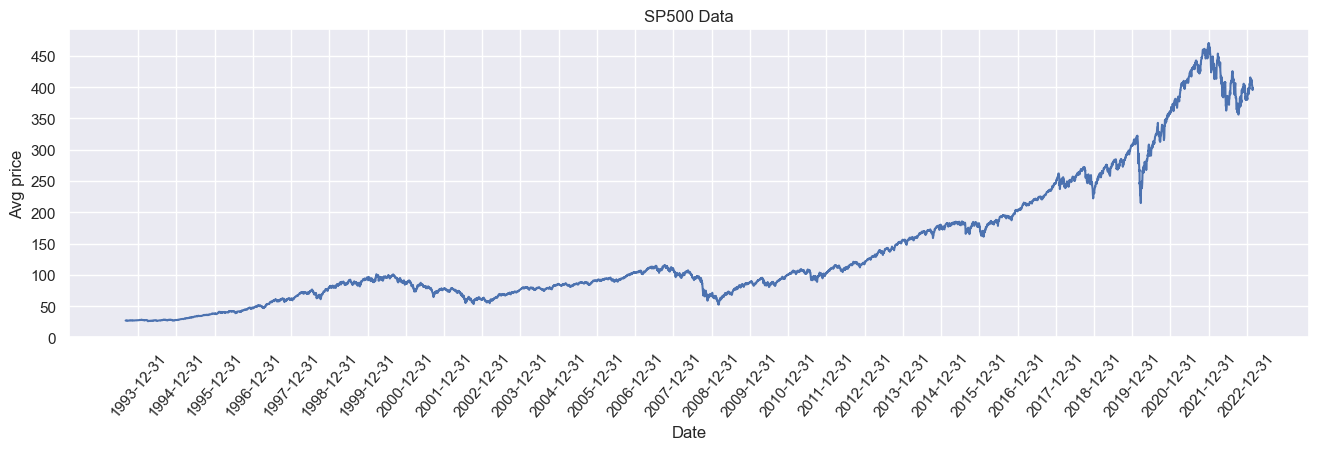

In [14]:
import seaborn as sns
from matplotlib.dates import DateFormatter

date_form = DateFormatter('%Y-%m-%d')

sns.set(rc={'figure.figsize':(16, 4)})
ax = sns.lineplot(x=df['Date'], y=df['avg'])
ax.set_yticks(range(0, 500, 50))
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(df['Date'].min(), df['Date'].max(), freq='Y'), rotation=50)
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

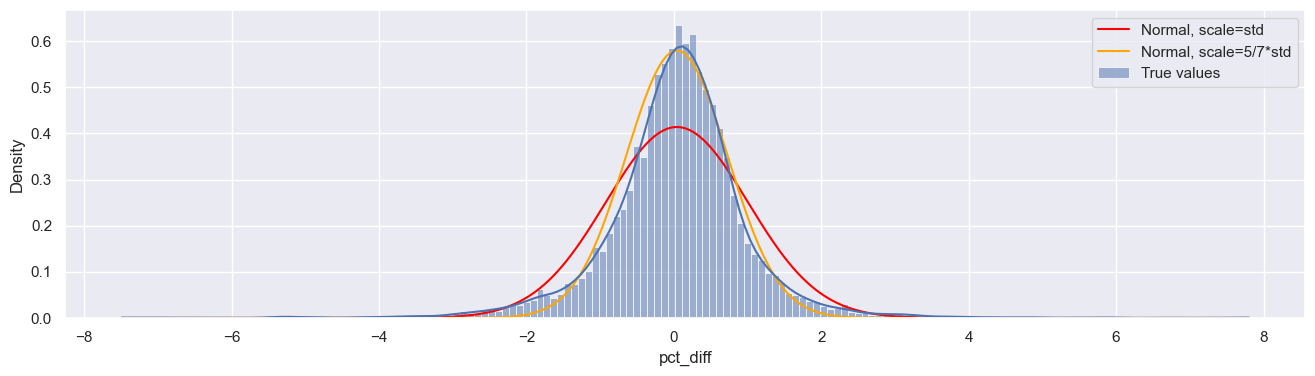

In [15]:
from scipy import stats

mean = df['pct_diff'].mean()
std = df['pct_diff'].std()

x = np.linspace(df['pct_diff'].min(), df['pct_diff'].max(), len(df))
pdf = stats.norm.pdf(x, loc=mean, scale=std)
pdf2 = stats.norm.pdf(x, loc=mean, scale=std*5/7)

sns.lineplot(x=x, y=pdf, color='red', label='Normal, scale=std')
sns.lineplot(x=x, y=pdf2, color='orange', label='Normal, scale=5/7*std')
sns.histplot(df['pct_diff'], stat='density', kde=True, label='True values')
plt.legend()
plt.show()

## LSTM

In [16]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

In [17]:
def rmse_calc(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    return rmse

def mape_calc(y_true, y_pred):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    return mape

In [18]:
split = int(len(df)*.8)

x = df.drop(['Tmrw_avg', 'pct', 'pct_diff'], axis=1)
y = df['Tmrw_avg']
y = y.values.reshape(-1,1)

x_train, x_test = x[:split], x[split:]
y_train, y_test = y[:split], y[split:]

train_dates = x_train['Date']
test_dates = x_test['Date']
x_test = x_test.drop('Date', axis=1)
x_train = x_train.drop('Date', axis=1)

In [19]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:
x_train_lr = x_train_scaled.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_test_lr = x_test_scaled.reshape((x_test.shape[0], 1, x_test.shape[1]))

In [20]:
x_train_lstm = []
x_test_lstm = []
timesteps = 20

for i in range(x_train_scaled[0].size):
    x_train_lstm.append([])
    x_test_lstm.append([])
    for j in range(timesteps, x_train_scaled.shape[0]):
        x_train_lstm[i].append(x_train_scaled[j-timesteps:j, i])
    for j in range(timesteps, x_test_scaled.shape[0]):
        x_test_lstm[i].append(x_test_scaled[j-timesteps:j, i])

x_train_lstm = np.moveaxis(x_train_lstm, [0], [2])
x_test_lstm = np.moveaxis(x_test_lstm, [0], [2])

y_train_lstm = np.array(y_train_scaled[timesteps:,-1])
y_test_lstm = np.array(y_test_scaled[timesteps:,-1])

y_train_lstm = y_train_lstm.reshape(len(y_train_lstm),1)
y_test_lstm = y_test_lstm.reshape(len(y_test_lstm),1)

train_dates = np.array(train_dates[timesteps:])
test_dates = np.array(test_dates[timesteps:])


C:\Users\Reed Oken\AppData\Local\Temp\ipykernel_19096\3687009771.py:23: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  test_dates = np.array(test_dates[timesteps:])


In [21]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min')
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
model = Sequential()
model.add(LSTM(64, input_shape=(x_train_lstm.shape[1], x_train_lstm.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(x_train_lstm, y_train_lstm, epochs=1000, batch_size=50, validation_data=(x_test_lstm, y_test_lstm), shuffle=False, verbose=2, callbacks=[early_stop, checkpoint])

Epoch 1/1000
119/119 - 2s - loss: 0.0057 - val_loss: 0.2193 - 2s/epoch - 20ms/step
Epoch 2/1000
119/119 - 1s - loss: 0.0038 - val_loss: 0.1701 - 647ms/epoch - 5ms/step
Epoch 3/1000
119/119 - 1s - loss: 0.0018 - val_loss: 0.1958 - 661ms/epoch - 6ms/step
Epoch 4/1000
119/119 - 1s - loss: 0.0020 - val_loss: 0.1512 - 667ms/epoch - 6ms/step
Epoch 5/1000
119/119 - 1s - loss: 0.0019 - val_loss: 0.1646 - 638ms/epoch - 5ms/step
Epoch 6/1000
119/119 - 1s - loss: 0.0012 - val_loss: 0.1782 - 639ms/epoch - 5ms/step
Epoch 7/1000
119/119 - 1s - loss: 0.0013 - val_loss: 0.1685 - 665ms/epoch - 6ms/step
Epoch 8/1000
119/119 - 1s - loss: 0.0011 - val_loss: 0.1534 - 693ms/epoch - 6ms/step
Epoch 9/1000
119/119 - 1s - loss: 0.0011 - val_loss: 0.1314 - 709ms/epoch - 6ms/step
Epoch 10/1000
119/119 - 1s - loss: 0.0011 - val_loss: 0.1069 - 742ms/epoch - 6ms/step
Epoch 11/1000
119/119 - 1s - loss: 0.0011 - val_loss: 0.1150 - 681ms/epoch - 6ms/step
Epoch 12/1000
119/119 - 1s - loss: 0.0012 - val_loss: 0.1031 - 76

In [27]:
best_model = load_model('best_model.h5')
y_pred = best_model.predict(x_test_lstm)
mse = np.mean((y_pred - y_test_lstm)**2)

46/46 [==============================] - 0s 2ms/step
MSE:  0.030
RMSE: 0.174
MAPE: 0.066


In [23]:
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test_lstm)

print('LSTM Scores')
print(f'R2:   {r2_score(y_test_inv, y_pred):.3f}')
print(f'MSE:  {mse:.3f}')
print(f'MAE:  {mean_absolute_error(y_test_inv, y_pred_inv):.3f}')
print(f'RMSE: {rmse_calc(y_test_inv, y_pred_inv):.3f}')
print(f'MAPE: {mape_calc(y_test_inv, y_pred_inv):.3f}')

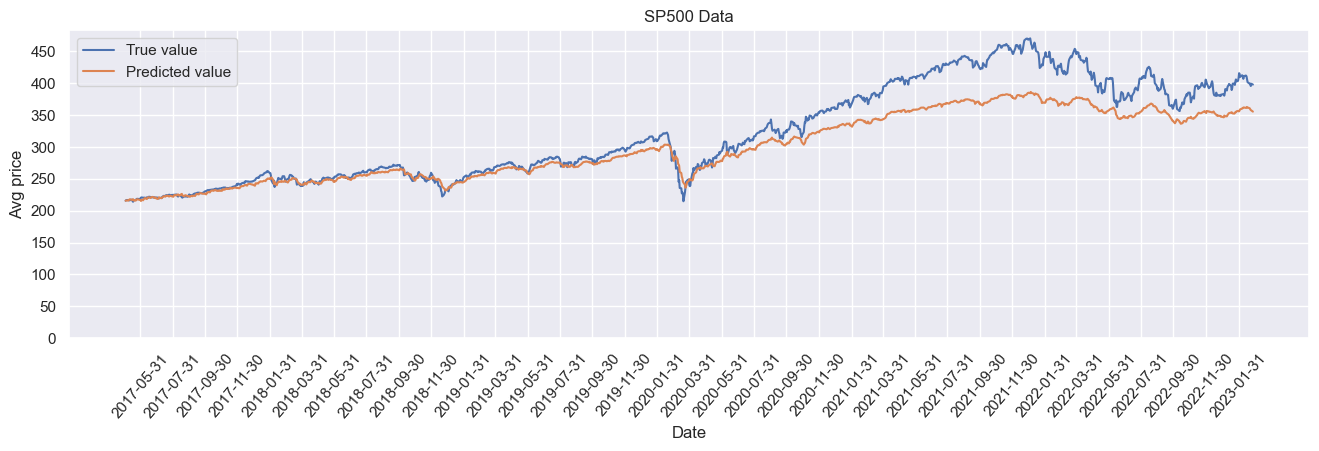

In [24]:
sns.set(rc={'figure.figsize':(16, 4)})
sns.lineplot(x=test_dates, y=y_test_inv.flatten(), label=f'True value')
sns.lineplot(x=test_dates, y=y_pred_inv.flatten(), label=f'Predicted value')
plt.title('SP500 Data')
plt.xlabel('Date')
plt.ylabel('Avg price')
plt.xticks(pd.date_range(test_dates.min(), df['Date'].max(), freq='2M'), rotation=50)
plt.yticks(range(0, 500, 50))
plt.gca().xaxis.set_major_formatter(date_form)
plt.show()

In [ ]:
plt.scatter(y_test_inv, y_pred_inv)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Long Short-Term Memory Model Fit')
plt.show()

### Linear Regression

In [ ]:
# Linear Regression- Import library
from sklearn.linear_model import LinearRegression

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(x_train_lr.reshape(x_train_lr.shape[0], -1), y_train_scaled)
lr_pred = lr_model.predict(x_test_lr.reshape(x_test_lr.shape[0], -1))
lr_pred = scaler_y.inverse_transform(lr_pred)

lr_mse = np.mean((lr_pred - y_test)**2)
lr_mae = mean_absolute_error(y_test, lr_pred)

# Calculate R-squared 
lr_r2 = r2_score(y_test, lr_pred)

# Print Linear Regression Mean Squared Error, Mean Absolute Error, and R-squared
print('Linear regression scores')
print(f'R-squared: {lr_r2:.3f}')
print(f'MSE: {lr_mse:.3f}')
print(f'MAE: {lr_mae:.3f}')
print(f'RMSE: {rmse_calc(y_test, lr_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, lr_pred):.3f}')

# Create scatterplot with model fit
plt.scatter(y_test, lr_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression Model Fit')
plt.show()

### SVM

In [ ]:
# Support Vector Regression - Import library
from sklearn.svm import SVR

# Support Vector Regression
svm_model = SVR(kernel='linear')
svm_model.fit(x_train_lr.reshape(x_train_lr.shape[0], -1), y_train_scaled.ravel())
svm_pred = svm_model.predict(x_test.reshape(x_test_lr.shape[0], -1))
svm_pred = scaler_y.inverse_transform(svm_pred)
svm_mse = np.mean((svm_pred - y_test)**2)

# Calculate R-squared and mean absolute error
svm_r2 = r2_score(y_test, svm_pred)
svm_mae = mean_absolute_error(y_test, svm_pred)

# Print SVM Mean Squared Error, Mean Absolute Error and R-squared
print('SVM Regression scores')
print('R-squared:', svm_r2)
print('MSE:', svm_mse)
print('MAE:', svm_mae)
print(f'RMSE: {rmse_calc(y_test, svm_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, svm_pred):.3f}')

# Create scatterplot with model fit
plt.scatter(y_test, svm_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Support Vector Regression Model Fit')
plt.show()


### Decision Tree 

In [ ]:
# Decision Tree Regression - Import library
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Regression
dt_model = DecisionTreeRegressor()
dt_model.fit(x_train_lr.reshape(x_train_lr.shape[0], -1), y_train_scaled)
dt_pred = dt_model.predict(x_test_lr.reshape(x_test_lr.shape[0], -1))
dt_pred = scaler_y.inverse_transform(dt_pred)
dt_mse = np.mean((dt_pred - y_test)**2)

# Calculate R-squared and mean absolute error
dt_r2 = r2_score(y_test, dt_pred)
dt_mae = mean_absolute_error(y_test, dt_pred)

# Print Decision Tree Mean Squared Error, Mean Absolute Error, and R-squared
print('Decision Tree regression scores')
print('R-squared:', dt_r2)
print('MSE:', dt_mse)
print('MAE:', dt_mae)
print(f'RMSE: {rmse_calc(y_test, dt_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, dt_pred):.3f}')


# Create scatterplot with model fit
plt.scatter(y_test, dt_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Decision Tree Model Fit')
plt.show()

### Gradient Boosting

In [ ]:
# Gradient Boosting Regression - Import library
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regression
gb_model = GradientBoostingRegressor(n_estimators=100)
gb_model.fit(x_train_lr.reshape(x_train_lr.shape[0], -1), y_train_scaled)
gb_pred = gb_model.predict(x_test_lr.reshape(x_test_lr.shape[0], -1))
gb_pred = scaler_y.inverse_transform(gb_pred)
gb_mse = np.mean((gb_pred - y_test)**2)

# Calculate R-squared and mean absolute error
gb_r2 = r2_score(y_test, gb_pred)
gb_mae = mean_absolute_error(y_test, gb_pred)

# Print Gradient Boosting Mean Squared Error, Mean Absolute Error, and R-squared
print('Grabient Boosting regression scores')
print('Gradient Boosting Regression MSE:', gb_mse)
print('Gradient Boosting Regression MAE:', gb_mae)
print('Gradient Boosting Regression R-squared:', gb_r2)
print(f'RMSE: {rmse_calc(y_test, gb_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, gb_pred):.3f}')

# Create scatterplot with model fit
plt.scatter(y_test, gb_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Gradient Boosting Regression Results')
plt.show()

### Random forest

In [ ]:
# Random Forest - Import library
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(x_train_lr.reshape(x_train_lr.shape[0], -1), y_train_scaled.ravel())
rf_pred = rf_model.predict(x_test_lr.reshape(x_test_lr.shape[0], -1))
rf_pred = scaler_y.inverse_transform(rf_pred)
rf_mse = np.mean((rf_pred - y_test)**2)

# Calculate R-squared and Mean Absolute Error
rf_r2 = r2_score(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)

# Print Random Forest Mean Squared Error, Mean Absolute Error, and R-squared
print('Random Forest regression scores')
print('R-squared:', rf_r2)
print('MSE:', rf_mse)
print('MAE:', rf_mae)
print(f'RMSE: {rmse_calc(y_test, rf_pred):.3f}')
print(f'MAPE: {mape_calc(y_test, rf_pred):.3f}')

# Create scatterplot with model fit
plt.scatter(y_test, rf_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression")
plt.show()